# Medical Insurance Cost Prediction
This notebook aims to analyze medical insurance data and build a predictive model for insurance costs.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


In [39]:
df = pd.read_csv('./insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [41]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


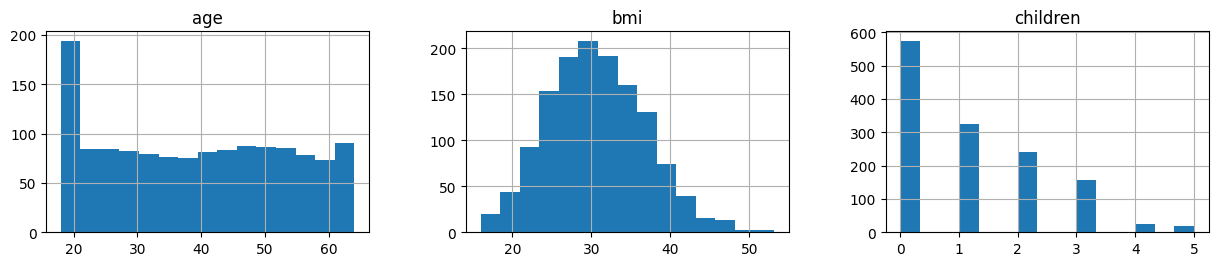

In [42]:
# Visualize the distribution of numerical variables
numerical_features = ['age', 'bmi', 'children']
df[numerical_features].hist(bins=15, figsize=(15, 6), layout=(2, 3));

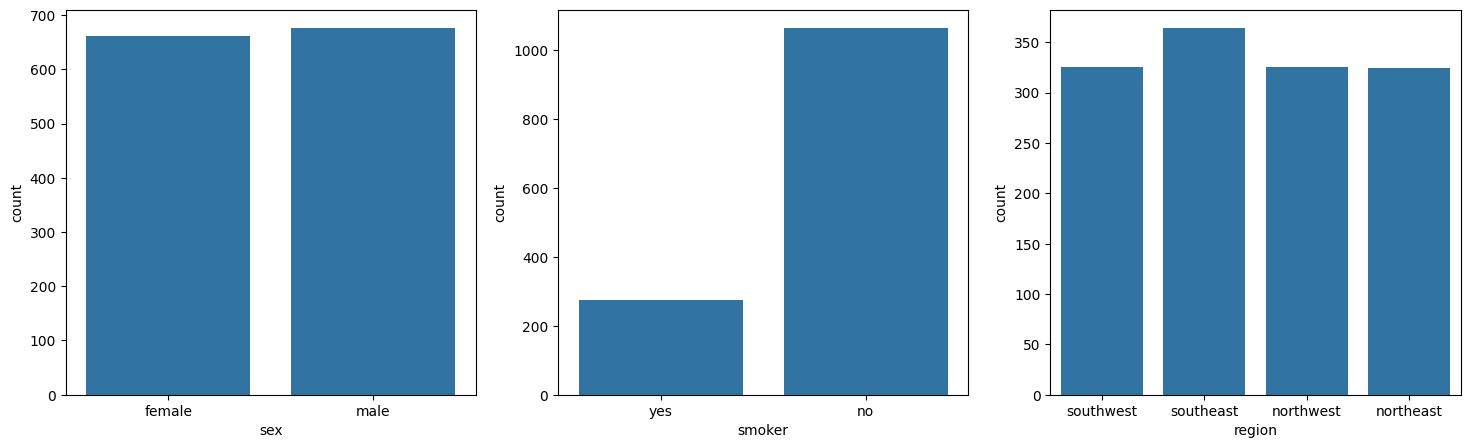

In [43]:
# Visualize categorical variables
categorical_features = ['sex', 'smoker', 'region']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, cat in enumerate(categorical_features):
    sns.countplot(data=df, x=cat, ax=axes[i])

In [44]:
# Encode categorical variables
df_encoded = df.copy()
df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})
df_encoded['sex'] = df_encoded['sex'].map({'female': 1, 'male': 0})
df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True)
df_encoded.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,False,False,True
1,18,0,33.770,1,0,1725.55230,False,True,False
2,28,0,33.000,3,0,4449.46200,False,True,False
3,33,0,22.705,0,0,21984.47061,True,False,False
4,32,0,28.880,0,0,3866.85520,True,False,False


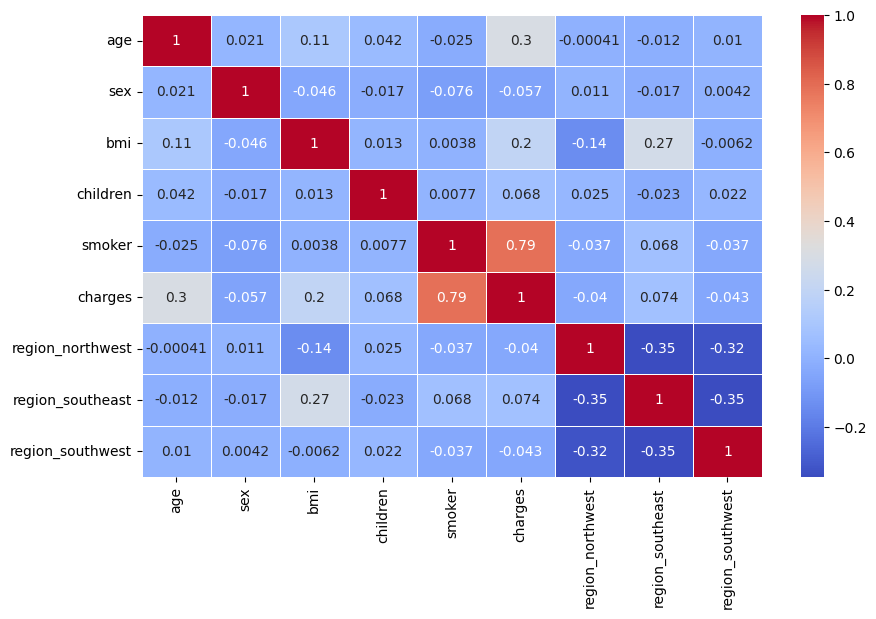

In [45]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [46]:
# Split the data into features and target
X = df_encoded.drop(columns=['charges'])
y = df_encoded['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1070, 8) (268, 8) (1070,) (268,)


In [47]:
# Define a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    return {'train_rmse': train_rmse, 'test_rmse': test_rmse, 'train_r2': train_r2, 'test_r2': test_r2}

In [48]:
from sklearn.compose import make_column_selector

numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

# Evaluate Linear Regression
linear_model = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', 'passthrough', categorical_features)
        ])),
    ('regressor', LinearRegression())
])
linear_results = evaluate_model(linear_model, X_train, y_train, X_test, y_test)
linear_results

{'train_rmse': 6105.545160099847,
 'test_rmse': 5796.284659276274,
 'train_r2': 0.7417255854683333,
 'test_r2': 0.7835929767120722}

In [49]:
# Evaluate Random Forest Regressor
rf_model = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', 'passthrough', categorical_features)
        ])),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test)
rf_results

{'train_rmse': 1935.134937723994,
 'test_rmse': 4544.225314908624,
 'train_r2': 0.9740549209737526,
 'test_r2': 0.8669877459594534}

In [50]:
# Evaluate Gradient Boosting Regressor
gb_model = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', 'passthrough', categorical_features)
        ])),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
gb_results = evaluate_model(gb_model, X_train, y_train, X_test, y_test)
gb_results

{'train_rmse': 3806.376558802036,
 'test_rmse': 4333.524168466749,
 'train_r2': 0.8996179662552334,
 'test_r2': 0.8790364884902101}

In [51]:
# Compare Model Results
results = pd.DataFrame([linear_results, rf_results, gb_results],
                      index=['Linear Regression', 'Random Forest', 'Gradient Boosting'])
results

,train_rmse,test_rmse,train_r2,test_r2
Linear Regression,6105.545160,5796.284659,0.741726,0.783593
Random Forest,1935.134938,4544.225315,0.974055,0.866988
Gradient Boosting,3806.376559,4333.524168,0.899618,0.879036


Text(0.5, 1.0, 'Feature Importance from Random Forest')

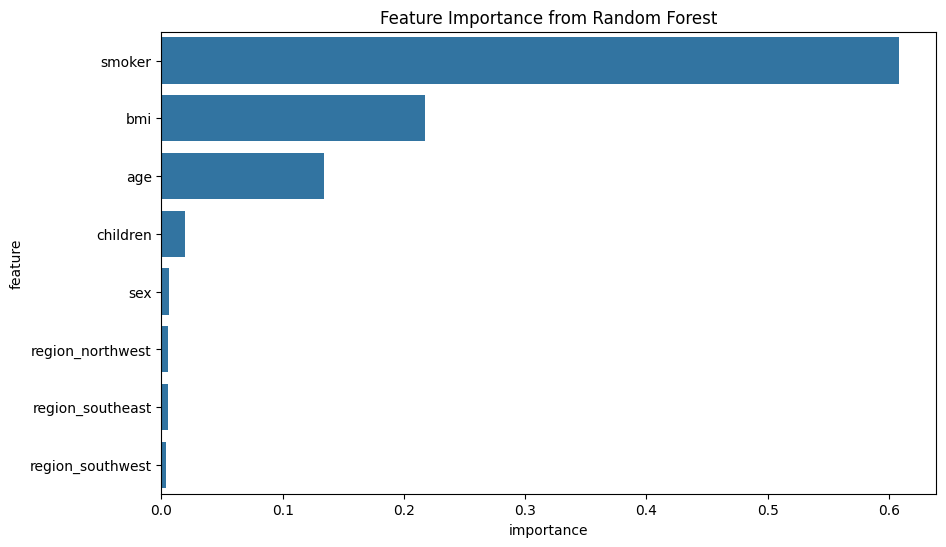

In [52]:
# Feature Importance from Random Forest
rf_model.fit(X_train, y_train)
importances = rf_model.named_steps['regressor'].feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')

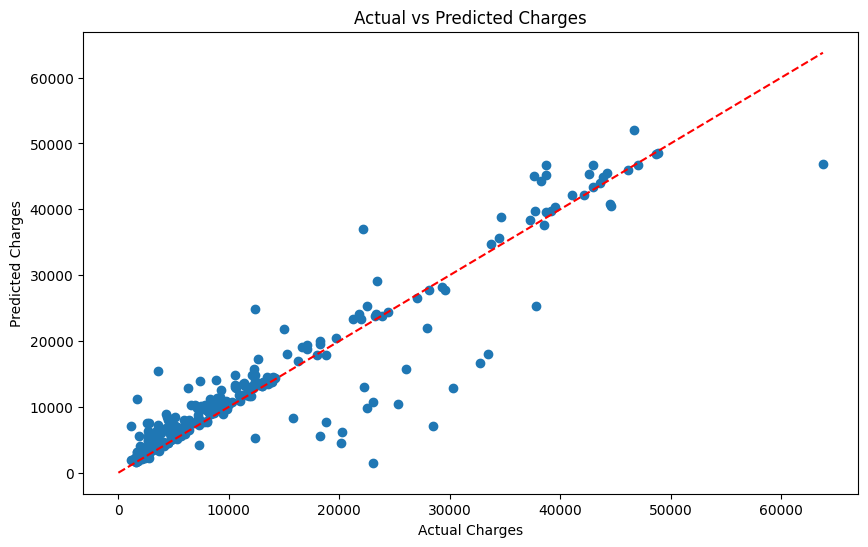

In [53]:
# Predictions vs Actuals
y_test_pred = rf_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], '--', color='red')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.show()